# Posterior predictive checks for the speed of light data

In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pymc3 as pm, arviz as az, os, scipy as sp
from scipy import stats
import plot_tools

## Normal model

In [11]:
# From Aki Vehtari's demos
# data
data_path = os.path.abspath(
    os.path.join(
        os.path.curdir,
        'utilities_and_data',
        'light.txt'
    )
)
y = np.loadtxt(data_path)
n = len(y)
s2 = np.var(y, ddof=1)  # Here ddof=1 is used to get the sample estimate.
s = np.sqrt(s2)
my = np.mean(y)

In [12]:
# scipy doesn't have the scaled inverse-chi-squared distribution, so we do the scale and inverse part ourselves
def get_sigma2(sd, n):
    x = sp.stats.chi2.rvs(n-1)
    y = 1/x
    y *= (n-1) * sd**2
    return y

# this is just a normal
def get_mu(ybar, sigma, n):
    return sp.stats.norm.rvs(ybar, sigma / np.sqrt(n))

In [13]:
def sample_posterior(ybar, sd, n):
    sigma2 = get_sigma2(sd, n)
    mu = get_mu(ybar, sigma2 ** (1/2), n)
    return (mu, sigma2)

def sample_posterior_predictive(ybar, sd, n):
    mu, sigma2 = sample_posterior(ybar, sd, n)
    return sp.stats.norm.rvs(mu, sigma2 ** 0.5)

In [14]:
replicates = np.array([[sample_posterior_predictive(my, s, n) for i in range(n)] for j in range(2000)])

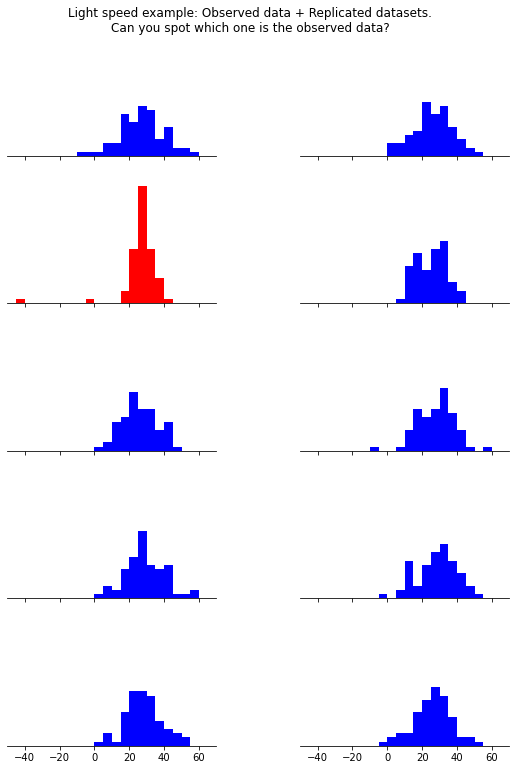

In [16]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
choices = np.random.permutation(2000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates[choices[order[i]]] if order[i] < 9 else y,
        np.arange(-45, 65, 5),
        color = 'blue' if order[i] < 9 else 'red'
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-50, 70])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

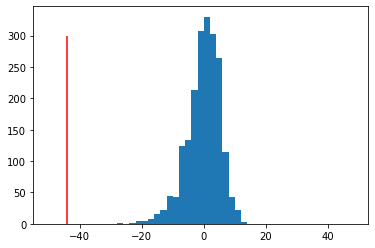

In [17]:
minimums = np.min(replicates, axis = 1)
plt.hist(minimums, bins=np.arange(-50, 50, 2))
plt.vlines(x=np.min(y), ymin=0, ymax=300, color = 'red')
plt.show()

## Student T model

In [19]:
# Student T Model
with pm.Model() as model:
    mu = pm.Flat('mu')
    sigma_log = pm.Flat('sigma_log')
    sigma = pm.Deterministic('sigma', pm.math.exp(sigma_log))
    y_ = pm.StudentT('y', nu = 3, mu = mu, sigma = sigma, observed = y)
    
    trace_T = pm.sample(2000)
    
    replicates = pm.sample_posterior_predictive(trace_T)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log, mu]
100%|██████████| 4000/4000 [00:02<00:00, 1571.51it/s]


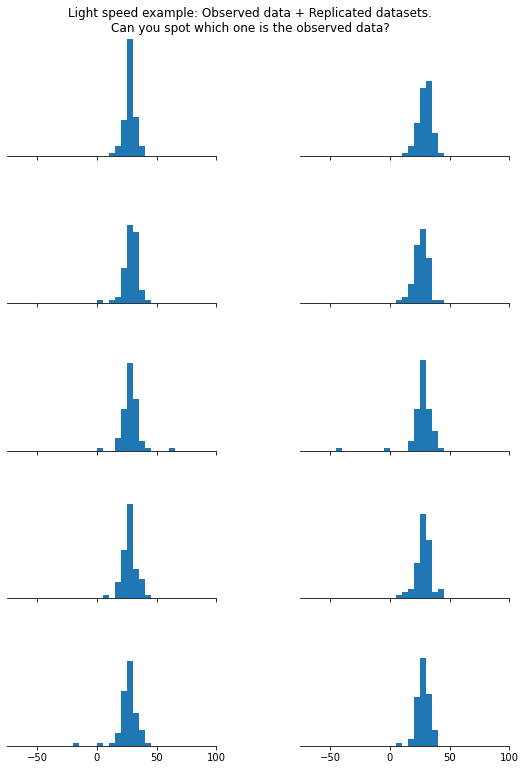

In [21]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
#np.random.seed(824792)
order = np.random.permutation(10)
choices = np.random.permutation(2000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates['y'][choices[order[i]]] if order[i] < 9 else y,
        np.arange(-75, 100, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-75, 100])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

In [ ]:
minimums = np.min(replicates['y'], axis = 1)
plt.hist(minimums, bins=np.arange(-250, 100, 4))
plt.vlines(x=np.min(y), ymin=0, ymax=200, color = 'red')
plt.show()

## Cauchy model

In [ ]:
# Cauchy Model
with pm.Model() as model:
    beta = pm.HalfCauchy('beta', 5)
    alpha = pm.Normal('alpha', 0, 50)
    y_ = pm.Cauchy('y', alpha = alpha, beta = beta, observed = y)
    
    trace_C = pm.sample()
    
    replicates = pm.sample_posterior_predictive(trace_C)

In [ ]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
choices = np.random.permutation(2000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates['y'][choices[order[i]]] if order[i] < 9 else y,
        np.arange(-75, 100, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-75, 100])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

In [ ]:
minimums = np.min(replicates['y'], axis = 1)
plt.hist(minimums, bins=np.arange(-750, 100, 4))
plt.vlines(x=np.min(y), ymin=0, ymax=70, color = 'red')
plt.show()